#Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import pickle
import itertools
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, precision_score, recall_score, f1_score

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

#Pre-processing

In [ ]:
# Read the metadata.csv file into a pandas DataFrame
path = '/content/drive/My Drive/DukeStudies/548L_MLI_Project/Git_Repo/'
# path = '/content/drive/MyDrive/Sp23/BME548L_Machine_Learning_and_Imaging/548L_MLI_Project/Skin_Lesion_Classification/HAM10000data/'
#path = '/content/drive/MyDrive/Sp23/BME548L_Machine_Learning_and_Imaging/548L_MLI_Project/Git_Repo/'

In [ ]:
# metadata = pd.read_csv(path+'train_metadata.csv')

In [ ]:
# def load_and_crop(image, crop_size, normalized=True):
#     width, height = image.size   # Get dimensions
#     left = (width - crop_size)/2
#     top = (height - crop_size)/2
#     right = (width + crop_size)/2
#     bottom = (height + crop_size)/2
#     # Crop the center of the image
#     # image = ImageOps.grayscale(image.crop((left, top, right, bottom)))
#     image = image.crop((left, top, right, bottom))
#     if normalized:
#         return np.array(image).astype(np.float32) / 255.0
#     else:
#         return np.array(image).astype(np.float32)

# # Load and preprocess the images
# images = []
# labels = []

# for i, row in metadata.iterrows():
#     image = load_img(row['image_path'], target_size=(150, 200))
#     image = load_and_crop(image, 128)
#     images.append(image)
#     labels.append(row['dx'])

#     if i % 100 == 0:
#         print('Now is processing the', i+1, 'th image')
#     if i % 1000 == 0:
#         print('Progress:', i/100, '%')
#     if i >= 10000:
#         print('Progress:', i+1, '/10015')

# # Convert the images and labels to numpy arrays and adding a fake color channel
# X = np.array(images).reshape(-1, 128, 128, 3)
# print(X.shape)
# y = np.array(labels)
# print(y.shape)

# # Convert the labels to integer values
# y = pd.Series(labels).factorize()[0]

# # Convert the labels to one-hot encoded vectors
# y = to_categorical(y)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# display(X_train.shape)
# display(X_test.shape)
# display(y_train.shape)
# display(y_test.shape)

# plt.imshow(X_train[0])

In [ ]:
# Load the training and test data
with open(path + 'augmented_datas.pickle', 'rb') as f:
    data = pickle.load(f)

# Separate the images and labels
X = data['X']
y = data['y']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Convert string labels to integer labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

# Convert integer labels to one-hot encoded arrays
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)

# Print the shape of the data
print('Training data shape:', X_train.shape)
print('Training labels shape:', y_train.shape)
print('Validation data shape:', X_val.shape)
print('Validation labels shape:', y_val.shape)
print('Test data shape:', X_test.shape)
print('Test labels shape:', y_test.shape)

Training data shape: (2016, 128, 128, 3)
Training labels shape: (2016, 7)
Validation data shape: (224, 128, 128, 3)
Validation labels shape: (224, 7)
Test data shape: (560, 128, 128, 3)
Test labels shape: (560, 7)


(-0.5, 127.5, 127.5, -0.5)

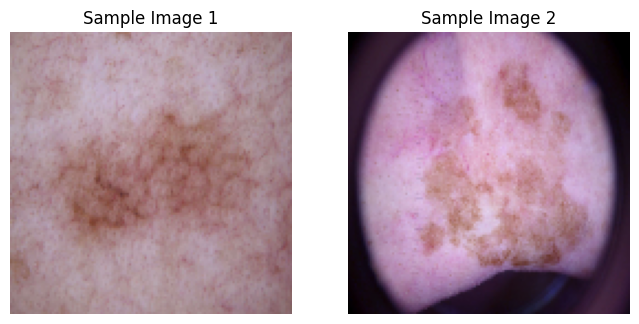

In [ ]:
sample_image1 = X_train[0]
sample_image2 = X_train[1]
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(cv2.cvtColor(sample_image1, cv2.COLOR_BGR2RGB))
ax[0].set_title("Sample Image 1")
ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(sample_image2, cv2.COLOR_BGR2RGB))
ax[1].set_title("Sample Image 2")
ax[1].axis('off')

In [ ]:
def metrics(X_test,y_test,trained_model):
  from sklearn.metrics import confusion_matrix
  data_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
  train_pred = trained_model.predict(X_train)
  train_pred_classes = np.argmax(train_pred,axis = 1)
  test_pred = trained_model.predict(X_test)
  # Convert predictions classes to one hot vectors 
  test_pred_classes = np.argmax(test_pred,axis = 1) 
  y_lab_c_mat = []
  for lab in y_test:
    y_lab_c_mat.append(np.argmax(lab))
  confusionmatrix = confusion_matrix(y_lab_c_mat, test_pred_classes)
  import seaborn as sns
  #mask = np.diag(np.ones(7))
  plt.figure(figsize=(10,10))
  sns.set(font_scale=1.4)
  sns.heatmap(confusionmatrix, cmap = "viridis", square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True, xticklabels=data_labels, yticklabels= data_labels,fmt='g')
  from sklearn.metrics import classification_report
  # Generate a classification report
  #trainreport = classification_report(trainlabels, train_pred_classes, target_names=list(labels))
  testreport = classification_report(y_lab_c_mat, test_pred_classes, target_names=data_labels)
  #print(trainreport)
  print(testreport)

#Baseline

In [ ]:
# Define a base model
image_size = (128, 128, 3)

# # Load the VGG16 model with imagenet weights
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=image_size)
# base_model.trainable = False

# # Load the ResNet152 model with imagenet weights
# base_model = tf.keras.applications.ResNet152(
#     include_top=False, weights='imagenet', input_shape=image_size)
# base_model.trainable = False

# Load the InceptionV3 model with imagenet weights
base_model = tf.keras.applications.InceptionV3(
    include_top=False, weights='imagenet',pooling='avg', input_shape=image_size)

#RGB Layer

In [ ]:
# Create new weighted RGB image
import tensorflow.keras.backend as K

class WeightedRGBLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(WeightedRGBLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Define the trainable weights for the RGB channels
        self.r_weights = self.add_weight(name='r_weights', shape=(1,), trainable=True, constraint=tf.keras.constraints.NonNeg())
        self.g_weights = self.add_weight(name='g_weights', shape=(1,), trainable=True, constraint=tf.keras.constraints.NonNeg())
        self.b_weights = self.add_weight(name='b_weights', shape=(1,), trainable=True, constraint=tf.keras.constraints.NonNeg())

    def call(self, inputs):
        # Split the input image into its RGB channels
        r, g, b = tf.split(inputs, num_or_size_splits=3, axis=-1)

        # Scale the RGB channels by the trainable weights
        r_scaled = r * self.r_weights
        g_scaled = g * self.g_weights
        b_scaled = b * self.b_weights

        # Merge the scaled RGB channels into an image
        merged = tf.concat([r_scaled, g_scaled, b_scaled], axis=-1)
        merged = tf.abs(merged)
        return merged

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
class PlotLayerOutputCallback(tf.keras.callbacks.Callback):
    def __init__(self, layer_index, img, plot_freq=5):
        super(PlotLayerOutputCallback, self).__init__()
        self.layer_index = layer_index
        self.plot_freq = plot_freq
        self.img = img
        
    def on_epoch_end(self, epoch, logs=None):
        
        # if epoch == 0:
        if (epoch+1) % self.plot_freq == 0:
            layer_output_func = tf.keras.backend.function([self.model.layers[0].input],
                                                           [self.model.layers[self.layer_index].output])
            layer_output = layer_output_func(self.img)[0]
            plt.imshow(layer_output[0])
            plt.show()
            rgb_weights = self.model.layers[1].get_weights()
            print("\nTrained RGB weights:\n")
            print(rgb_weights)

plot_callback = PlotLayerOutputCallback(layer_index = 0, plot_freq = 7, img = X_train[40:42])

#Lens Distortion 1

##Simulating distortion

The following custom layer is used for simulating the distortion by running images through it before being fed into the classification model. The lens distortion is achieved by constructing a camera matrix, consisting of 5 definable parameters/coefficients, k1, k2, k3 (which are manipulated below to create the two distortions), f (camera focal length, set to 35 for both distortions), cx and cy (defines the optical center, both are set to 64 to mark the center of the 128x128 image). The layer essentially undistorts the image with the distortion matrix. Since, simulations is being done on undistorted images, by applying undistortion with say pincushion distortion, images undergo barrel distortion.

In [ ]:
class LensDistortionLayer(tf.keras.layers.Layer):

    def __init__(self, k1, k2, k3, f, cx, cy):
        super().__init__()
        self.k1 = k1
        self.k2 = k2
        self.k3 = k3
        self.f = f
        self.cx = cx
        self.cy = cy
        self.camera_matrix = np.array([[f, 0, cx],
                                       [0, f, cy],
                                       [0, 0, 1]])
        self.dist_coeffs = np.array([k1, k2, k3, 0, 0])

    def build(self, input_shape=(128,128,3)):
        super().build(input_shape)

    def call(self, inputs):
        # Apply the distortion matrix to the image.
        distorted_image = cv2.undistort(inputs, self.camera_matrix, self.dist_coeffs)

        # Convert the distorted image back to a tensor.
        distorted_image = tf.convert_to_tensor(distorted_image)

        return distorted_image

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
lensdistort = LensDistortionLayer(k1=-0.01, k2=-0.05, k3=0.01,f=45,cx=64,cy=64)

In [ ]:
# Create a new array to store the distorted images.
X_train_distorted = []

# Iterate over the images in X_train.
for image in X_train:
    # Apply the distortion function to the image.
    distorted_image = lensdistort.call(image)

    # Add the distorted image to the new array.
    X_train_distorted.append(distorted_image)

# Convert the new array to a NumPy array.
X_train_distorted = np.array(X_train_distorted)

In [ ]:
# Create a new array to store the distorted images.
X_val_distorted = []

# Iterate over the images in X_val.
for image in X_val:
    # Apply the distortion function to the image.
    distorted_image = lensdistort.call(image)

    # Add the distorted image to the new array.
    X_val_distorted.append(distorted_image)

# Convert the new array to a NumPy array.
X_val_distorted = np.array(X_val_distorted)

In [ ]:
# Create a new array to store the distorted images.
X_test_distorted = []

# Iterate over the images in X_test.
for image in X_test:
    # Apply the distortion function to the image.
    distorted_image = lensdistort.call(image)

    # Add the distorted image to the new array.
    X_test_distorted.append(distorted_image)

# Convert the new array to a NumPy array.
X_test_distorted = np.array(X_test_distorted)

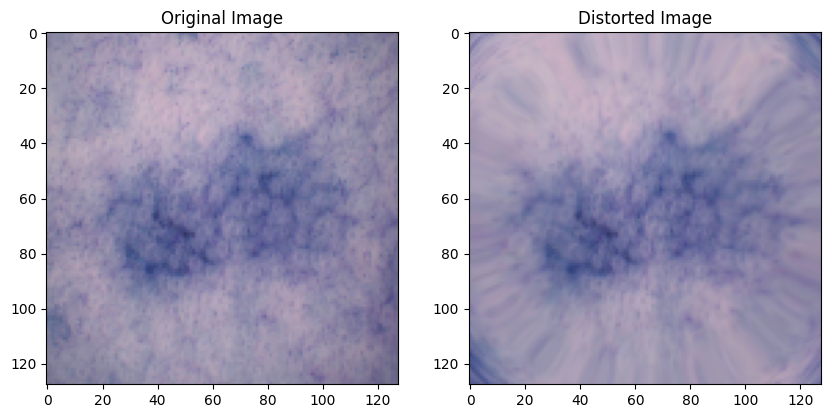

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(X_train[0])
axes[0].set_title('Original Image')
axes[1].imshow(X_train_distorted[0])
axes[1].set_title('Distorted Image')
plt.show()

##Without RGB layer

In [ ]:
model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.Input(image_size),
    
    # Gaussian Blur
    #GaussianBlur2D(sigma=1),

    # RGB regenerate layer
    #WeightedRGBLayer(),
    
    # batch Normalization layer
    tf.keras.layers.BatchNormalization(),

    base_model,
    Dropout(0.5),
    Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)),
    Dropout(0.5),
    

#     # # convolutional layers:
#     # tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides = 1, activation='relu'),
#     # tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides = 4, activation='relu'),
#     # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 1, activation='relu'),
#     # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 3, activation='relu'),

#     # # dense layers:
#     # tf.keras.layers.Flatten(),
#     # tf.keras.layers.Dense(32, activation='relu'),
      Dense(7, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02))
])

# Compile the model with an Adam optimizer and cross-entropy loss function
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_188 (Ba  (None, 128, 128, 3)      12        
 tchNormalization)                                               
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                        

In [ ]:
# Train model with callback
hist = model.fit(X_train_distorted, y_train, batch_size=20, epochs=35, validation_data=(X_val_distorted, y_val))

Epoch 1/35
101/101 [==============================] - 57s 110ms/step - loss: 7.0554 - accuracy: 0.2267 - val_loss: 6.7929 - val_accuracy: 0.1964
Epoch 2/35
101/101 [==============================] - 7s 68ms/step - loss: 6.2633 - accuracy: 0.3819 - val_loss: 5.8154 - val_accuracy: 0.5670
Epoch 3/35
101/101 [==============================] - 7s 70ms/step - loss: 5.6706 - accuracy: 0.5149 - val_loss: 5.2038 - val_accuracy: 0.6295
Epoch 4/35
101/101 [==============================] - 7s 72ms/step - loss: 5.1502 - accuracy: 0.6146 - val_loss: 4.7501 - val_accuracy: 0.6875
Epoch 5/35
101/101 [==============================] - 7s 70ms/step - loss: 4.6233 - accuracy: 0.7063 - val_loss: 4.4114 - val_accuracy: 0.7188
Epoch 6/35
101/101 [==============================] - 7s 71ms/step - loss: 4.2067 - accuracy: 0.7619 - val_loss: 4.0753 - val_accuracy: 0.7679
Epoch 7/35
101/101 [==============================] - 7s 71ms/step - loss: 3.7598 - accuracy: 0.8413 - val_loss: 3.7203 - val_accuracy: 0.77

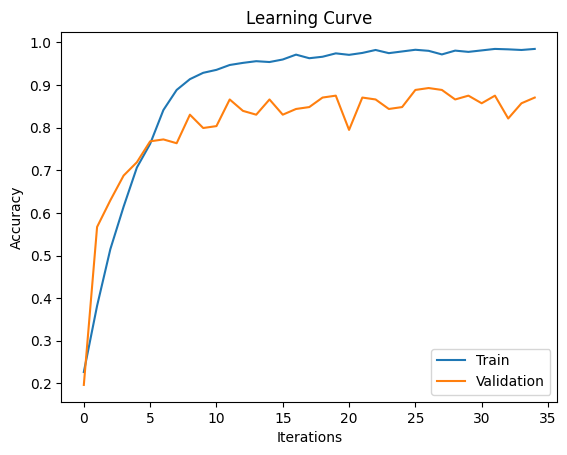

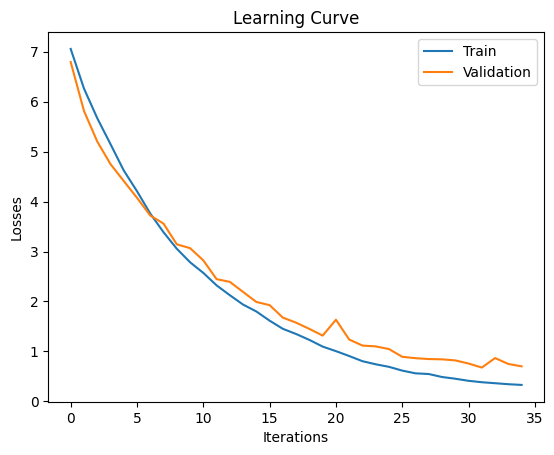

In [ ]:
plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('accuracy'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_accuracy'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('loss'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_loss'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Losses")
plt.legend(loc='best')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# evaluate the model on the test dataset
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5) # convert probabilities to binary predictions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

cm = multilabel_confusion_matrix(y_test, y_pred)

# calculate precision, recall, and F1 score
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1_score = f1_score(y_test, y_pred, average='micro')

print('Confusion Matrix:\n', cm)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score)

18/18 [==============================] - 1s 25ms/step - loss: 1.3437 - accuracy: 0.6875
Test accuracy: 0.6875
18/18 [==============================] - 2s 22ms/step
Confusion Matrix:
 [[[487   0]
  [ 70   3]]

 [[455  22]
  [ 11  72]]

 [[424  60]
  [ 14  62]]

 [[470  13]
  [ 28  49]]

 [[460  14]
  [ 43  43]]

 [[449  22]
  [  9  80]]

 [[484   0]
  [  1  75]]]
Precision: 0.7456310679611651
Recall: 0.6857142857142857
F1 Score: 0.7144186046511628


18/18 [==============================] - 0s 22ms/step
              precision    recall  f1-score   support

       akiec       1.00      0.04      0.08        73
         bcc       0.70      0.87      0.77        83
         bkl       0.47      0.82      0.60        76
          df       0.73      0.64      0.68        77
         mel       0.67      0.51      0.58        86
          nv       0.70      0.90      0.79        89
        vasc       0.99      0.99      0.99        76

    accuracy                           0.69       560
   macro avg       0.75      0.68      0.64       560
weighted avg       0.75      0.69      0.65       560



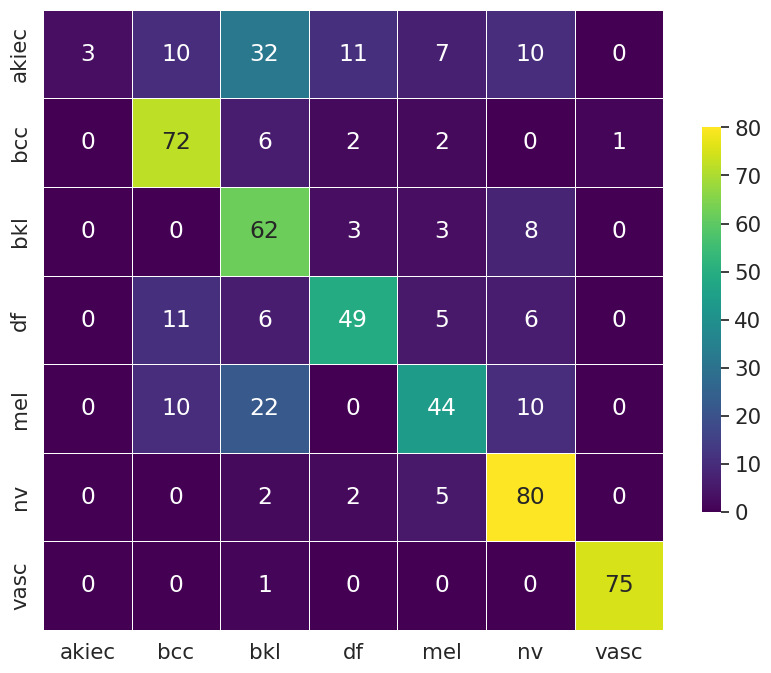

In [ ]:
metrics(X_test, y_test, model)

##With RGB Layer

In [ ]:
model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.Input(image_size),
    
    # Gaussian Blur
    #GaussianBlur2D(sigma=1),

    # RGB regenerate layer
    WeightedRGBLayer(),
    
    # batch Normalization layer
    tf.keras.layers.BatchNormalization(),

    base_model,
    Dropout(0.5),
    Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)),
    Dropout(0.5),
    

#     # # convolutional layers:
#     # tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides = 1, activation='relu'),
#     # tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides = 4, activation='relu'),
#     # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 1, activation='relu'),
#     # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 3, activation='relu'),

#     # # dense layers:
#     # tf.keras.layers.Flatten(),
#     # tf.keras.layers.Dense(32, activation='relu'),
      Dense(7, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02))
])

# Compile the model with an Adam optimizer and cross-entropy loss function
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 weighted_rgb_layer (Weighte  (None, 128, 128, 3)      3         
 dRGBLayer)                                                      
                                                                 
 batch_normalization_189 (Ba  (None, 128, 128, 3)      12        
 tchNormalization)                                               
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)              

Epoch 1/35
101/101 [==============================] - 43s 83ms/step - loss: 5.4591 - accuracy: 0.8274 - val_loss: 7.3339 - val_accuracy: 0.2946
Epoch 2/35
101/101 [==============================] - 7s 70ms/step - loss: 4.5611 - accuracy: 0.9653 - val_loss: 7.8904 - val_accuracy: 0.4196
Epoch 3/35
101/101 [==============================] - 7s 71ms/step - loss: 4.0647 - accuracy: 0.9593 - val_loss: 8.8747 - val_accuracy: 0.4375
Epoch 4/35
101/101 [==============================] - 7s 71ms/step - loss: 3.5540 - accuracy: 0.9618 - val_loss: 6.0152 - val_accuracy: 0.5179
Epoch 5/35
101/101 [==============================] - 7s 71ms/step - loss: 3.0764 - accuracy: 0.9717 - val_loss: 4.0035 - val_accuracy: 0.7098
Epoch 6/35
101/101 [==============================] - 7s 72ms/step - loss: 2.7022 - accuracy: 0.9663 - val_loss: 2.9233 - val_accuracy: 0.8125
Epoch 7/35
101/101 [==============================] - ETA: 0s - loss: 2.3599 - accuracy: 0.9663

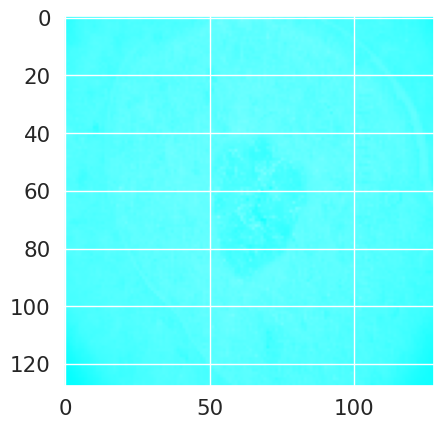


Trained RGB weights:

[array([1.0063646, 0.9938657, 1.0002842], dtype=float32), array([ 0.00225137, -0.00191223, -0.00176662], dtype=float32), array([  0.30288336, 234.51485   , 107.93143   ], dtype=float32), array([7.0839617e-03, 3.3660837e+03, 2.9431424e+02], dtype=float32)]
101/101 [==============================] - 7s 73ms/step - loss: 2.3599 - accuracy: 0.9663 - val_loss: 2.5062 - val_accuracy: 0.8705
Epoch 8/35
101/101 [==============================] - 7s 70ms/step - loss: 2.0103 - accuracy: 0.9807 - val_loss: 2.1337 - val_accuracy: 0.8839
Epoch 9/35
101/101 [==============================] - 7s 70ms/step - loss: 1.7590 - accuracy: 0.9792 - val_loss: 1.9446 - val_accuracy: 0.8616
Epoch 10/35
101/101 [==============================] - 7s 69ms/step - loss: 1.5148 - accuracy: 0.9797 - val_loss: 1.7307 - val_accuracy: 0.8705
Epoch 11/35
101/101 [==============================] - 7s 70ms/step - loss: 1.3288 - accuracy: 0.9797 - val_loss: 1.5287 - val_accuracy: 0.8884
Epoch 12/35
101

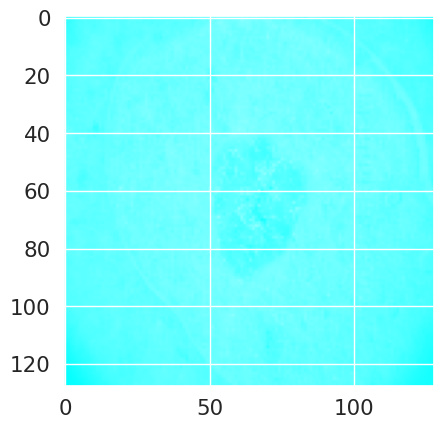


Trained RGB weights:

[array([1.0063812 , 0.99521303, 0.99772745], dtype=float32), array([ 0.00199567, -0.00361194, -0.00029743], dtype=float32), array([  0.34388995, 235.07278   , 107.8332    ], dtype=float32), array([7.5937728e-03, 3.3328718e+03, 2.9061307e+02], dtype=float32)]
101/101 [==============================] - 7s 73ms/step - loss: 0.8826 - accuracy: 0.9812 - val_loss: 1.1028 - val_accuracy: 0.8705
Epoch 15/35
101/101 [==============================] - 7s 70ms/step - loss: 0.7504 - accuracy: 0.9891 - val_loss: 1.0784 - val_accuracy: 0.8795
Epoch 16/35
101/101 [==============================] - 7s 71ms/step - loss: 0.6496 - accuracy: 0.9906 - val_loss: 0.9552 - val_accuracy: 0.8884
Epoch 17/35
101/101 [==============================] - 7s 70ms/step - loss: 0.5746 - accuracy: 0.9916 - val_loss: 0.8201 - val_accuracy: 0.9018
Epoch 18/35
101/101 [==============================] - 7s 70ms/step - loss: 0.5304 - accuracy: 0.9831 - val_loss: 0.9303 - val_accuracy: 0.8661
Epoch 19/3

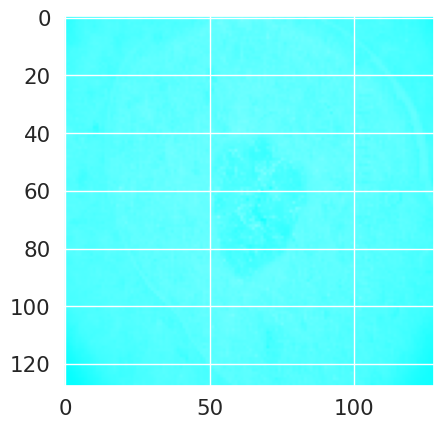


Trained RGB weights:

[array([1.0039943 , 0.99676394, 0.9993468 ], dtype=float32), array([ 0.00139561, -0.00185403, -0.00143371], dtype=float32), array([  0.30657238, 235.00133   , 107.31301   ], dtype=float32), array([6.1089629e-03, 3.3803657e+03, 2.9215039e+02], dtype=float32)]
101/101 [==============================] - 7s 72ms/step - loss: 0.3994 - accuracy: 0.9821 - val_loss: 0.7931 - val_accuracy: 0.8527
Epoch 22/35
101/101 [==============================] - 7s 70ms/step - loss: 0.3517 - accuracy: 0.9891 - val_loss: 0.7620 - val_accuracy: 0.8661
Epoch 23/35
101/101 [==============================] - 7s 70ms/step - loss: 0.3169 - accuracy: 0.9891 - val_loss: 0.7414 - val_accuracy: 0.8661
Epoch 24/35
101/101 [==============================] - 7s 70ms/step - loss: 0.2998 - accuracy: 0.9906 - val_loss: 0.7191 - val_accuracy: 0.8839
Epoch 25/35
101/101 [==============================] - 7s 70ms/step - loss: 0.2829 - accuracy: 0.9866 - val_loss: 0.5323 - val_accuracy: 0.9107
Epoch 26/3

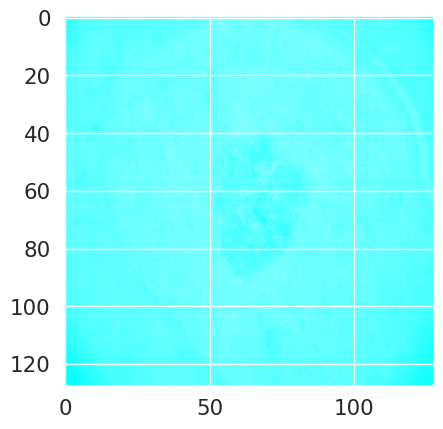


Trained RGB weights:

[array([1.0045024, 0.9958561, 1.0001094], dtype=float32), array([ 0.00156822, -0.00121026, -0.00340632], dtype=float32), array([  0.37138012, 234.92268   , 107.18571   ], dtype=float32), array([8.9637525e-03, 3.3779861e+03, 2.8983282e+02], dtype=float32)]
101/101 [==============================] - 7s 73ms/step - loss: 0.2384 - accuracy: 0.9886 - val_loss: 0.5955 - val_accuracy: 0.8884
Epoch 29/35
101/101 [==============================] - 7s 70ms/step - loss: 0.2149 - accuracy: 0.9911 - val_loss: 0.6085 - val_accuracy: 0.8616
Epoch 30/35
101/101 [==============================] - 7s 71ms/step - loss: 0.2208 - accuracy: 0.9861 - val_loss: 0.4469 - val_accuracy: 0.9062
Epoch 31/35
101/101 [==============================] - 7s 70ms/step - loss: 0.2014 - accuracy: 0.9931 - val_loss: 0.4854 - val_accuracy: 0.8973
Epoch 32/35
101/101 [==============================] - 7s 70ms/step - loss: 0.2098 - accuracy: 0.9861 - val_loss: 0.5513 - val_accuracy: 0.8839
Epoch 33/35
1

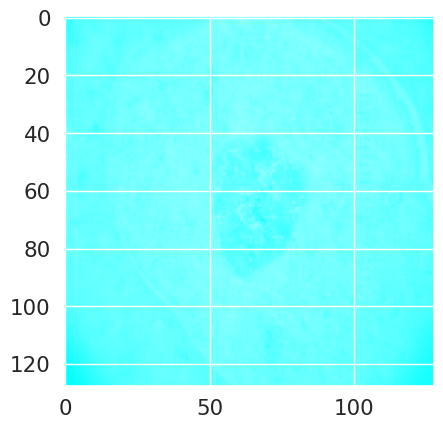


Trained RGB weights:

[array([1.004183 , 0.9969053, 0.9988328], dtype=float32), array([ 0.00241641, -0.0023354 , -0.00368376], dtype=float32), array([  0.3722753, 234.89276  , 106.5321   ], dtype=float32), array([8.9882836e-03, 3.3632458e+03, 2.8526031e+02], dtype=float32)]
101/101 [==============================] - 7s 73ms/step - loss: 0.1762 - accuracy: 0.9926 - val_loss: 0.4619 - val_accuracy: 0.8929


In [ ]:
# Train model with callback
hist = model.fit(X_train_distorted, y_train, batch_size=20, epochs=35, validation_data=(X_val_distorted, y_val), callbacks=[plot_callback])

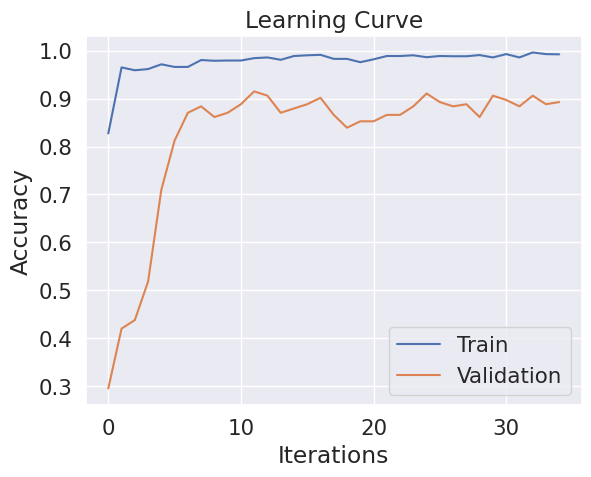

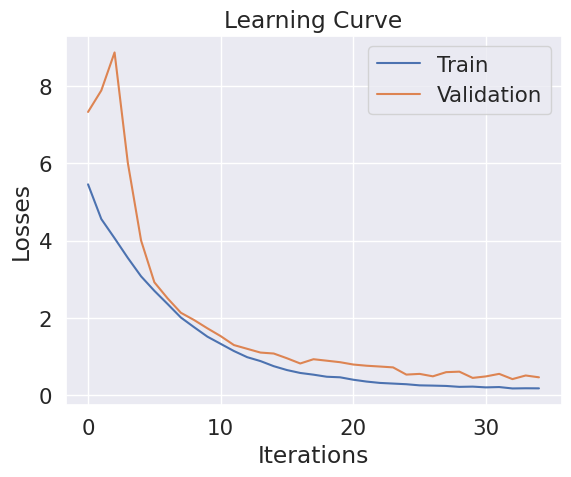

In [ ]:
plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('accuracy'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_accuracy'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('loss'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_loss'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Losses")
plt.legend(loc='best')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# evaluate the model on the test dataset
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5) # convert probabilities to binary predictions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

cm = multilabel_confusion_matrix(y_test, y_pred)

# calculate precision, recall, and F1 score
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1_score = f1_score(y_test, y_pred, average='micro')

print('Confusion Matrix:\n', cm)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score)

18/18 [==============================] - 0s 24ms/step - loss: 1.0741 - accuracy: 0.7357
Test accuracy: 0.7357142567634583
18/18 [==============================] - 2s 22ms/step
Confusion Matrix:
 [[[487   0]
  [ 65   8]]

 [[466  11]
  [ 24  59]]

 [[466  18]
  [ 16  60]]

 [[427  56]
  [  4  73]]

 [[460  14]
  [ 37  49]]

 [[459  12]
  [  9  80]]

 [[481   3]
  [  0  76]]]
Precision: 0.7803468208092486
Recall: 0.7232142857142857
F1 Score: 0.7506950880444856


18/18 [==============================] - 0s 22ms/step
              precision    recall  f1-score   support

       akiec       1.00      0.16      0.28        73
         bcc       0.82      0.72      0.77        83
         bkl       0.73      0.80      0.77        76
          df       0.50      0.95      0.66        77
         mel       0.71      0.58      0.64        86
          nv       0.83      0.90      0.86        89
        vasc       0.94      1.00      0.97        76

    accuracy                           0.74       560
   macro avg       0.79      0.73      0.71       560
weighted avg       0.79      0.74      0.71       560



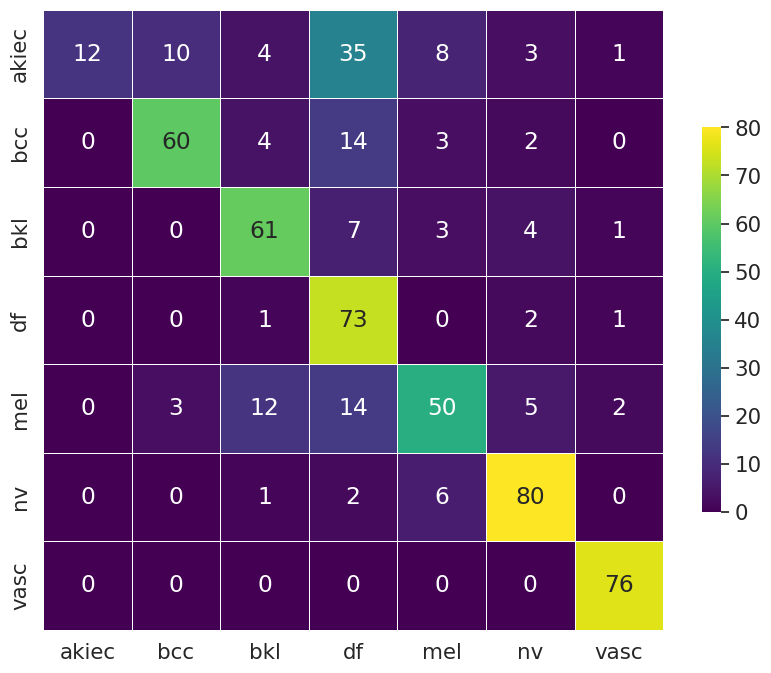

In [ ]:
metrics(X_test, y_test, model)

#Barrel Distortion

##Simulating distortion

In [ ]:
lensdistort = LensDistortionLayer(k1=0.01, k2=0.05, k3=0.01,f=45,cx=64,cy=64)

In [ ]:
# Create a new array to store the distorted images.
X_train_distorted = []

# Iterate over the images in X_train.
for image in X_train:
    # Apply the distortion function to the image.
    distorted_image = lensdistort.call(image)

    # Add the distorted image to the new array.
    X_train_distorted.append(distorted_image)

# Convert the new array to a NumPy array.
X_train_distorted = np.array(X_train_distorted)

In [ ]:
# Create a new array to store the distorted images.
X_val_distorted = []

# Iterate over the images in X_val.
for image in X_val:
    # Apply the distortion function to the image.
    distorted_image = lensdistort.call(image)

    # Add the distorted image to the new array.
    X_val_distorted.append(distorted_image)

# Convert the new array to a NumPy array.
X_val_distorted = np.array(X_val_distorted)

In [ ]:
# Create a new array to store the distorted images.
X_test_distorted = []

# Iterate over the images in X_test.
for image in X_test:
    # Apply the distortion function to the image.
    distorted_image = lensdistort.call(image)

    # Add the distorted image to the new array.
    X_test_distorted.append(distorted_image)

# Convert the new array to a NumPy array.
X_test_distorted = np.array(X_test_distorted)

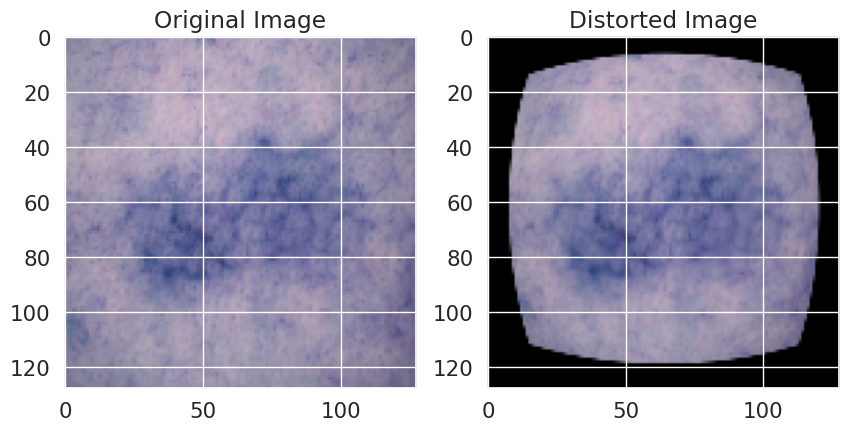

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(X_train[0])
axes[0].set_title('Original Image')
axes[1].imshow(X_train_distorted[0])
axes[1].set_title('Distorted Image')
plt.show()

##Without RGB Layer

In [ ]:
model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.Input(image_size),
    
    # Gaussian Blur
    #GaussianBlur2D(sigma=1),

    # RGB regenerate layer
    #WeightedRGBLayer(),
    
    # batch Normalization layer
    tf.keras.layers.BatchNormalization(),

    base_model,
    Dropout(0.5),
    Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)),
    Dropout(0.5),
    

#     # # convolutional layers:
#     # tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides = 1, activation='relu'),
#     # tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides = 4, activation='relu'),
#     # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 1, activation='relu'),
#     # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 3, activation='relu'),

#     # # dense layers:
#     # tf.keras.layers.Flatten(),
#     # tf.keras.layers.Dense(32, activation='relu'),
      Dense(7, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02))
])

# Compile the model with an Adam optimizer and cross-entropy loss function
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_194 (Ba  (None, 128, 128, 3)      12        
 tchNormalization)                                               
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dropout_12 (Dropout)        (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               262272    
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 7)                 903       
                                                      

In [ ]:
# Train model with callback
hist = model.fit(X_train_distorted, y_train, batch_size=20, epochs=35, validation_data=(X_val_distorted, y_val))

Epoch 1/35
101/101 [==============================] - 42s 82ms/step - loss: 5.3060 - accuracy: 0.8770 - val_loss: 5.9837 - val_accuracy: 0.7366
Epoch 2/35
101/101 [==============================] - 7s 69ms/step - loss: 4.4605 - accuracy: 0.9965 - val_loss: 4.7876 - val_accuracy: 0.8750
Epoch 3/35
101/101 [==============================] - 7s 70ms/step - loss: 3.9093 - accuracy: 0.9955 - val_loss: 4.1405 - val_accuracy: 0.8795
Epoch 4/35
101/101 [==============================] - 7s 70ms/step - loss: 3.3734 - accuracy: 0.9950 - val_loss: 3.5852 - val_accuracy: 0.8884
Epoch 5/35
101/101 [==============================] - 7s 71ms/step - loss: 2.8731 - accuracy: 0.9945 - val_loss: 3.0178 - val_accuracy: 0.8839
Epoch 6/35
101/101 [==============================] - 7s 70ms/step - loss: 2.4188 - accuracy: 0.9960 - val_loss: 2.7065 - val_accuracy: 0.8750
Epoch 7/35
101/101 [==============================] - 7s 70ms/step - loss: 2.0350 - accuracy: 0.9945 - val_loss: 2.2235 - val_accuracy: 0.906

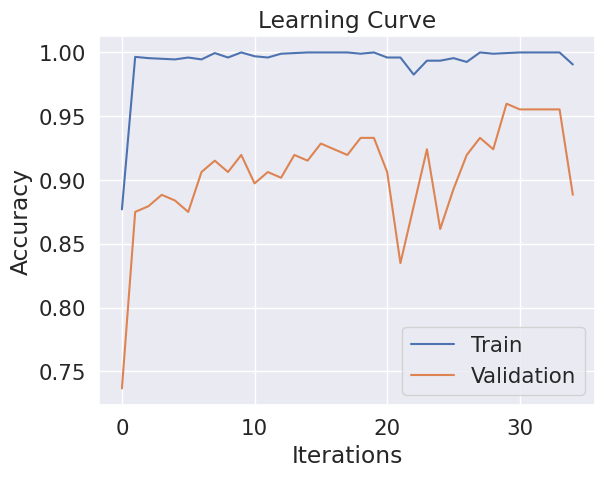

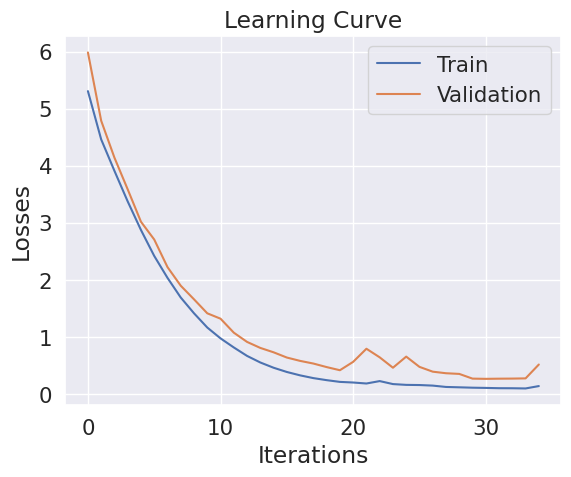

In [ ]:
plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('accuracy'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_accuracy'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('loss'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_loss'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Losses")
plt.legend(loc='best')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# evaluate the model on the test dataset
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5) # convert probabilities to binary predictions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

cm = multilabel_confusion_matrix(y_test, y_pred)

# calculate precision, recall, and F1 score
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1_score = f1_score(y_test, y_pred, average='micro')

print('Confusion Matrix:\n', cm)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score)

18/18 [==============================] - 0s 24ms/step - loss: 0.4757 - accuracy: 0.8911
Test accuracy: 0.8910714387893677
18/18 [==============================] - 2s 22ms/step
Confusion Matrix:
 [[[484   3]
  [ 13  60]]

 [[475   2]
  [ 17  66]]

 [[465  19]
  [  2  74]]

 [[478   5]
  [  8  69]]

 [[459  15]
  [ 11  75]]

 [[467   4]
  [ 13  76]]

 [[482   2]
  [  1  75]]]
Precision: 0.908256880733945
Recall: 0.8839285714285714
F1 Score: 0.8959276018099548


18/18 [==============================] - 0s 22ms/step
              precision    recall  f1-score   support

       akiec       0.94      0.85      0.89        73
         bcc       0.97      0.81      0.88        83
         bkl       0.75      0.97      0.85        76
          df       0.92      0.90      0.91        77
         mel       0.81      0.87      0.84        86
          nv       0.95      0.87      0.91        89
        vasc       0.97      0.99      0.98        76

    accuracy                           0.89       560
   macro avg       0.90      0.89      0.89       560
weighted avg       0.90      0.89      0.89       560



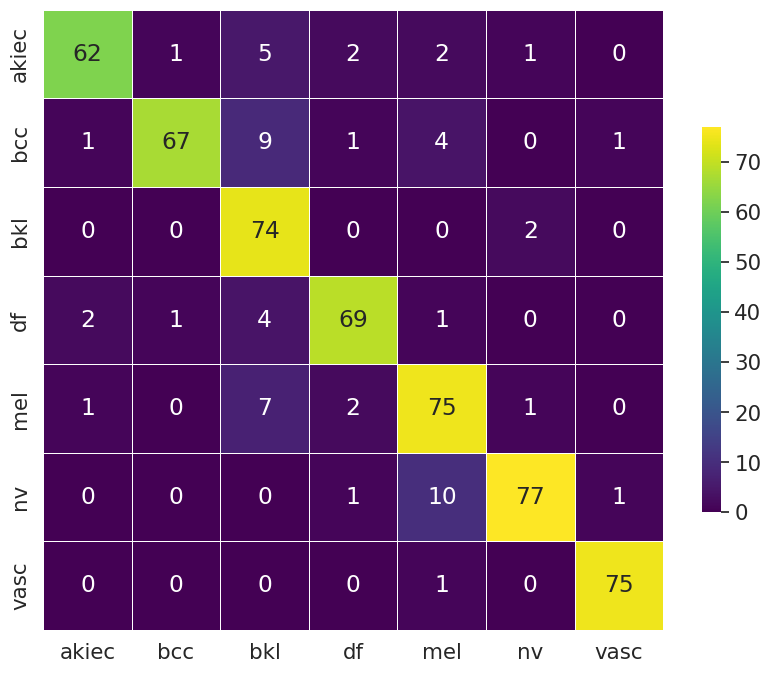

In [ ]:
metrics(X_test, y_test, model)

##With RGB Layer

In [ ]:
model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.Input(image_size),
    
    # Gaussian Blur
    #GaussianBlur2D(sigma=1),

    # RGB regenerate layer
    WeightedRGBLayer(),
    
    # batch Normalization layer
    tf.keras.layers.BatchNormalization(),

    base_model,
    Dropout(0.5),
    Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)),
    Dropout(0.5),
    

#     # # convolutional layers:
#     # tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides = 1, activation='relu'),
#     # tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides = 4, activation='relu'),
#     # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 1, activation='relu'),
#     # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 3, activation='relu'),

#     # # dense layers:
#     # tf.keras.layers.Flatten(),
#     # tf.keras.layers.Dense(32, activation='relu'),
      Dense(7, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02))
])

# Compile the model with an Adam optimizer and cross-entropy loss function
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 weighted_rgb_layer_2 (Weigh  (None, 128, 128, 3)      3         
 tedRGBLayer)                                                    
                                                                 
 batch_normalization_193 (Ba  (None, 128, 128, 3)      12        
 tchNormalization)                                               
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dropout_10 (Dropout)        (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 128)               262272    
                                                                 
 dropout_11 (Dropout)        (None, 128)              

Epoch 1/35
101/101 [==============================] - 42s 83ms/step - loss: 5.2460 - accuracy: 0.8938 - val_loss: 5.8366 - val_accuracy: 0.6920
Epoch 2/35
101/101 [==============================] - 7s 70ms/step - loss: 4.4210 - accuracy: 0.9950 - val_loss: 4.8114 - val_accuracy: 0.8482
Epoch 3/35
101/101 [==============================] - 7s 71ms/step - loss: 3.8840 - accuracy: 0.9906 - val_loss: 4.2403 - val_accuracy: 0.8348
Epoch 4/35
101/101 [==============================] - 7s 71ms/step - loss: 3.3268 - accuracy: 0.9921 - val_loss: 3.5556 - val_accuracy: 0.8884
Epoch 5/35
101/101 [==============================] - 7s 71ms/step - loss: 2.8236 - accuracy: 0.9955 - val_loss: 3.0509 - val_accuracy: 0.8973
Epoch 6/35
101/101 [==============================] - 7s 71ms/step - loss: 2.3742 - accuracy: 0.9980 - val_loss: 2.4237 - val_accuracy: 0.9286
Epoch 7/35
101/101 [==============================] - ETA: 0s - loss: 2.0159 - accuracy: 0.9921

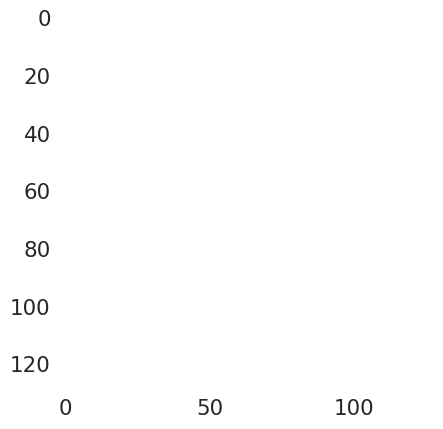


Trained RGB weights:

[array([0.99917597, 1.0006394 , 0.99972963], dtype=float32), array([-3.9361726e-04,  2.1451680e-05, -1.7156125e-03], dtype=float32), array([148.08612,  41.14515, 126.40161], dtype=float32), array([11393.867  ,   872.61633,  7416.459  ], dtype=float32)]
101/101 [==============================] - 7s 72ms/step - loss: 2.0159 - accuracy: 0.9921 - val_loss: 2.2911 - val_accuracy: 0.8839
Epoch 8/35
101/101 [==============================] - 7s 70ms/step - loss: 1.6678 - accuracy: 0.9970 - val_loss: 1.9402 - val_accuracy: 0.8973
Epoch 9/35
101/101 [==============================] - 7s 70ms/step - loss: 1.3827 - accuracy: 0.9985 - val_loss: 1.6389 - val_accuracy: 0.8973
Epoch 10/35
101/101 [==============================] - 7s 70ms/step - loss: 1.1589 - accuracy: 0.9950 - val_loss: 1.5305 - val_accuracy: 0.8973
Epoch 11/35
101/101 [==============================] - 7s 70ms/step - loss: 0.9654 - accuracy: 0.9960 - val_loss: 1.2698 - val_accuracy: 0.8929
Epoch 12/35
101/10

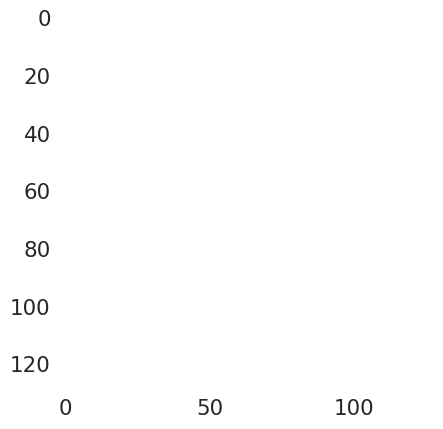


Trained RGB weights:

[array([0.9990661, 1.0005862, 1.0001552], dtype=float32), array([-0.00108711, -0.00121176, -0.00058161], dtype=float32), array([148.49115 ,  41.282116, 126.63079 ], dtype=float32), array([11448.093  ,   877.59875,  7433.13   ], dtype=float32)]
101/101 [==============================] - 7s 72ms/step - loss: 0.5492 - accuracy: 0.9990 - val_loss: 0.8605 - val_accuracy: 0.9018
Epoch 15/35
101/101 [==============================] - 7s 71ms/step - loss: 0.4824 - accuracy: 0.9955 - val_loss: 0.7942 - val_accuracy: 0.8973
Epoch 16/35
101/101 [==============================] - 7s 70ms/step - loss: 0.4079 - accuracy: 0.9965 - val_loss: 0.7588 - val_accuracy: 0.8795
Epoch 17/35
101/101 [==============================] - 7s 71ms/step - loss: 0.3407 - accuracy: 0.9975 - val_loss: 0.6695 - val_accuracy: 0.9062
Epoch 18/35
101/101 [==============================] - 7s 70ms/step - loss: 0.3045 - accuracy: 0.9945 - val_loss: 0.6353 - val_accuracy: 0.8884
Epoch 19/35
101/101 [====

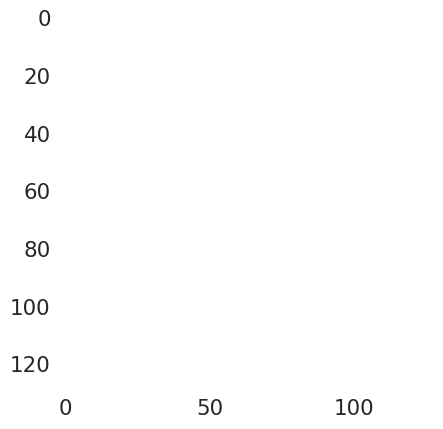


Trained RGB weights:

[array([0.9966008, 1.0025826, 1.0017561], dtype=float32), array([ 0.0002921 , -0.00429598, -0.00310786], dtype=float32), array([148.34692,  41.18021, 126.21019], dtype=float32), array([11427.76   ,   873.65784,  7387.8735 ], dtype=float32)]
101/101 [==============================] - 7s 72ms/step - loss: 0.2100 - accuracy: 0.9960 - val_loss: 0.5061 - val_accuracy: 0.9062
Epoch 22/35
101/101 [==============================] - 7s 70ms/step - loss: 0.1931 - accuracy: 0.9955 - val_loss: 0.5250 - val_accuracy: 0.9062
Epoch 23/35
101/101 [==============================] - 7s 70ms/step - loss: 0.1637 - accuracy: 1.0000 - val_loss: 0.5046 - val_accuracy: 0.8973
Epoch 24/35
101/101 [==============================] - 7s 70ms/step - loss: 0.1494 - accuracy: 0.9995 - val_loss: 0.4663 - val_accuracy: 0.9062
Epoch 25/35
101/101 [==============================] - 7s 70ms/step - loss: 0.1394 - accuracy: 0.9995 - val_loss: 0.4225 - val_accuracy: 0.9152
Epoch 26/35
101/101 [=======

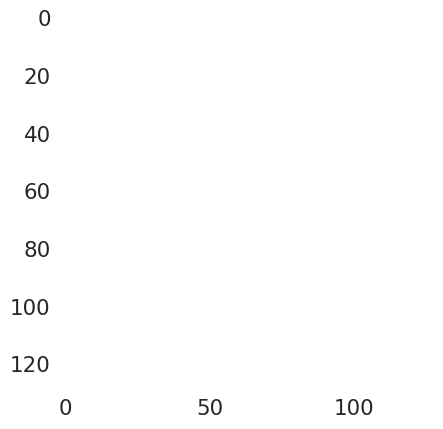


Trained RGB weights:

[array([0.99696654, 1.0034126 , 0.9988777 ], dtype=float32), array([-0.00227352, -0.00330213, -0.00202387], dtype=float32), array([148.40637 ,  41.197926, 126.53195 ], dtype=float32), array([11433.66  ,   874.0517,  7416.7886], dtype=float32)]
101/101 [==============================] - 7s 72ms/step - loss: 0.1409 - accuracy: 0.9945 - val_loss: 0.8465 - val_accuracy: 0.8482
Epoch 29/35
101/101 [==============================] - 7s 70ms/step - loss: 0.1392 - accuracy: 0.9945 - val_loss: 0.6215 - val_accuracy: 0.8750
Epoch 30/35
101/101 [==============================] - 7s 70ms/step - loss: 0.1176 - accuracy: 0.9990 - val_loss: 0.5697 - val_accuracy: 0.8661
Epoch 31/35
101/101 [==============================] - 7s 70ms/step - loss: 0.1244 - accuracy: 0.9955 - val_loss: 0.5207 - val_accuracy: 0.8929
Epoch 32/35
101/101 [==============================] - 7s 69ms/step - loss: 0.1167 - accuracy: 0.9985 - val_loss: 0.7009 - val_accuracy: 0.8527
Epoch 33/35
101/101 [====

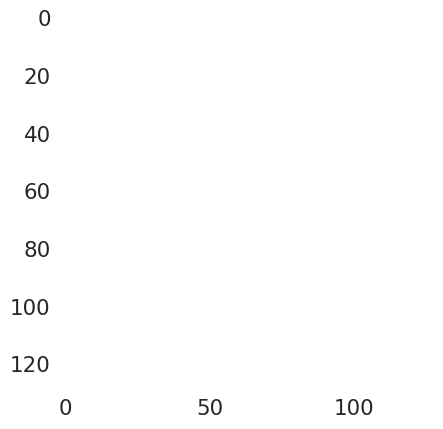


Trained RGB weights:

[array([0.9946157, 1.0042514, 1.0024258], dtype=float32), array([-0.00052244, -0.00482329, -0.00387137], dtype=float32), array([148.60503,  40.97538, 126.13418], dtype=float32), array([11479.083 ,   865.7017,  7380.384 ], dtype=float32)]
101/101 [==============================] - 7s 72ms/step - loss: 0.1340 - accuracy: 0.9921 - val_loss: 0.8282 - val_accuracy: 0.8438


In [ ]:
# Train model with callback
hist = model.fit(X_train_distorted, y_train, batch_size=20, epochs=35, validation_data=(X_val_distorted, y_val), callbacks=[plot_callback])

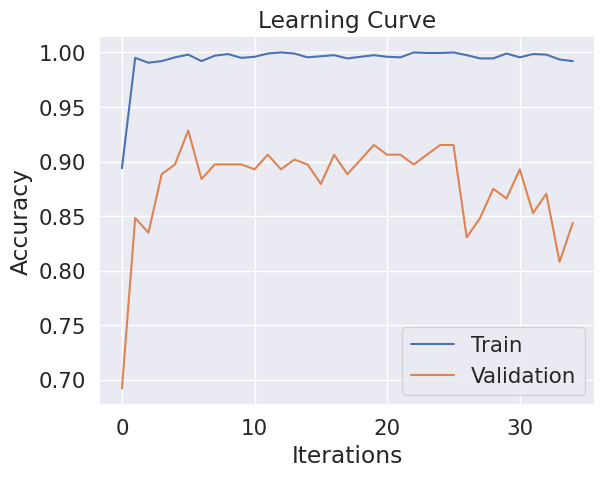

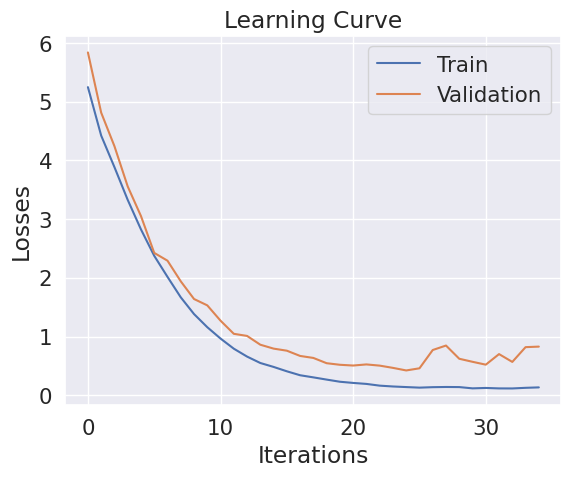

In [ ]:
plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('accuracy'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_accuracy'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('loss'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_loss'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Losses")
plt.legend(loc='best')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# evaluate the model on the test dataset
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5) # convert probabilities to binary predictions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

cm = multilabel_confusion_matrix(y_test, y_pred)

# calculate precision, recall, and F1 score
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1_score = f1_score(y_test, y_pred, average='micro')

print('Confusion Matrix:\n', cm)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score)

18/18 [==============================] - 0s 24ms/step - loss: 0.6730 - accuracy: 0.8661
Test accuracy: 0.8660714030265808
18/18 [==============================] - 2s 22ms/step
Confusion Matrix:
 [[[449  38]
  [  7  66]]

 [[476   1]
  [ 34  49]]

 [[483   1]
  [ 22  54]]

 [[474   9]
  [  7  70]]

 [[464  10]
  [  7  79]]

 [[460  11]
  [  5  84]]

 [[484   0]
  [  0  76]]]
Precision: 0.8722627737226277
Recall: 0.8535714285714285
F1 Score: 0.8628158844765343


18/18 [==============================] - 0s 22ms/step
              precision    recall  f1-score   support

       akiec       0.62      0.90      0.74        73
         bcc       0.98      0.61      0.76        83
         bkl       0.98      0.74      0.84        76
          df       0.86      0.91      0.89        77
         mel       0.89      0.94      0.92        86
          nv       0.88      0.96      0.91        89
        vasc       1.00      1.00      1.00        76

    accuracy                           0.87       560
   macro avg       0.89      0.87      0.86       560
weighted avg       0.89      0.87      0.87       560



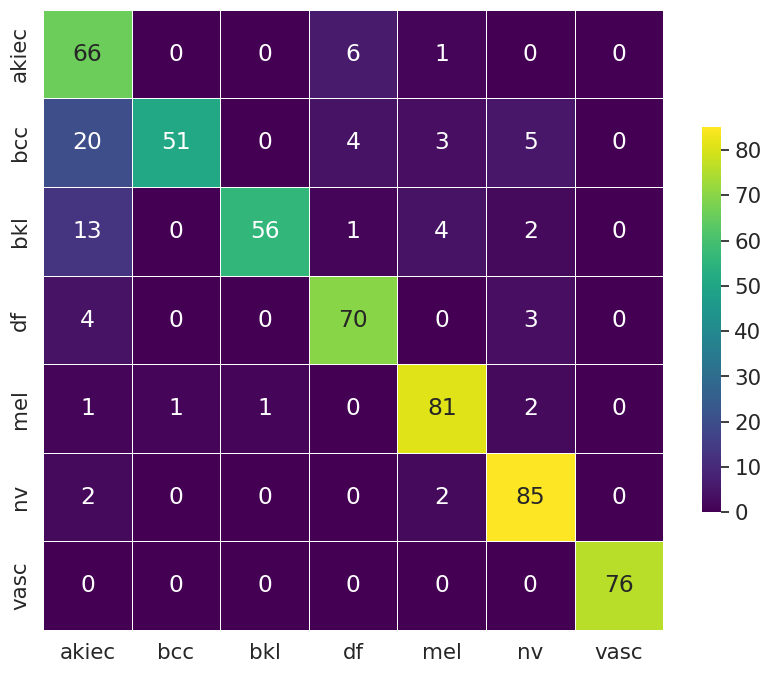

In [ ]:
metrics(X_test, y_test, model)